# Using Price Providers

In [3]:
from simple_back import price_providers

In [4]:
prices = price_providers.YahooFinanceProvider()

In [3]:
prices['AAPL','2015-1-2','open']

101.82906658545272

In [4]:
prices['AAPL',:,'open'][:5]

1980-12-12    0.405683
1980-12-15    0.386281
1980-12-16    0.358060
1980-12-17    0.365115
1980-12-18    0.375698
dtype: float64

In [5]:
prices['AAPL'][:5]

,open,high,low,close,adjclose,volume,ticker
1980-12-12,0.513393,0.515625,0.513393,0.513393,0.405683,117258400.0,AAPL
1980-12-15,0.488839,0.488839,0.486607,0.486607,0.384517,43971200.0,AAPL
1980-12-16,0.453125,0.453125,0.450893,0.450893,0.356296,26432000.0,AAPL
1980-12-17,0.462054,0.464286,0.462054,0.462054,0.365115,21610400.0,AAPL
1980-12-18,0.475446,0.477679,0.475446,0.475446,0.375698,18362400.0,AAPL


# Backtesting
### Price
Use ``price`` to get the current price of a symbol. Given a number, it will go back that amount of days, which can be used to compute averages, etc.
### Available Capital & Capital
While ``capital`` is the current value of your portfolio + cash, ``available_capital`` is capital not tied up in securities only.
### Order
Use ``order`` to enter a long trade of the given ticker, using the given funds (either use an absolute number or a percentage when passing ``as_percent=True``). To enter a short position, pass ``short=True``.
### Portfolio
``portfolio`` is a dataframe that contains information about all currently held positions.
### Liquidate
Use ``liquidate`` to get out of positions. Simply pass a filter for ``portfolio`` and all entries matching it will be liquidated.

In [1]:
from simple_back.backtester import Backtester
from datetime import date
from dateutil.relativedelta import relativedelta
from tqdm.auto import tqdm

## Iterator
The backtester object can be iterated over to run simple strategies.
It exposes ``day`` (e.g. 2010-01-01), ``event`` ('open' or 'close') and itself.

In [5]:
bt = Backtester(10_000, prices, market_calendar='NYSE', start_date='2019-4-1', end_date=date.today()-relativedelta(weeks=1))
ticker = 'QQQ'
for day, event, b in tqdm(bt):
    # calculate average price of the ticker over the last 30 days
    avg = b.price(ticker,30).mean()
    # liquidate all positions with the ticker symbol
    b.liquidate(ticker, num_shares=10)
    b.liquidate(ticker, short=True)
    # enter long position if the price is higher than the mean of the last 30 days
    if b.price(ticker) > avg:
        b.order(ticker, 1, as_percent=True)
    # do the opposite if the price is lower
    if b.price(ticker) < avg:
        b.order(ticker, b.available_capital, short=True)

TypeError: _get_value() missing 1 required positional argument: 'col'

In [9]:
bt.portfolio.at[0,'num_shares']

54.0

## Plotting

In [8]:
import matplotlib.pyplot as plt

### Values
``values`` tracks the value of the backtest over time.

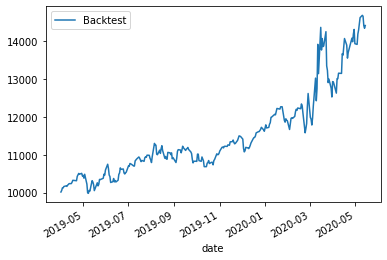

In [9]:
bt.values.plot()
plt.show()

In [10]:
bt.metrics

{'Max Drawdown': -0.06352573481133783, 'Annual Return': 1.3839983999388656}

### Compare
``compare`` constructs a dataframe which combines ``values`` with the returns of one or more other securities.

E.g. ``bt.compare(['AAPL','MSFT'])`` compares our backtest's returns with the returns had we invested in Microsoft or Apple instead.

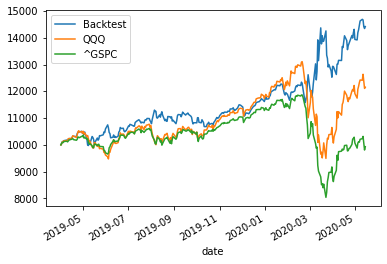

In [11]:
bt.compare(['QQQ','^GSPC']).plot()
plt.show()

In [12]:
import seaborn as sns

### Profit Loss
``profit_loss`` contains daily profit loss values.

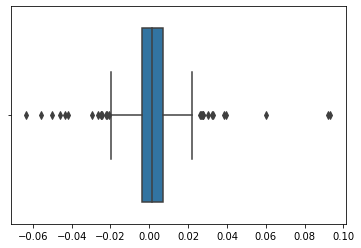

In [13]:
sns.boxplot(bt.profit_loss)
plt.show()

### Compare Profit Loss
To compare the profit and loss of different securities with our backtest, use ``compare_pl``.

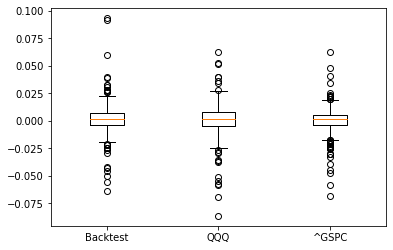

In [14]:
plt.boxplot(bt.compare_pl(['QQQ','^GSPC']), labels=['Backtest', 'QQQ', '^GSPC'])
plt.show()

## Strategy Class
If you want to write more involved strategies that can't operate in a stateless way, you can use the ``Strategy`` class. Below is the exact same strategy as shown before, but implemented using said class. The only methods that need to be implemented are ``open`` and ``close``.
### Advantages
This class does not only track state, it can also take advantage of multiprocessing for faster results.
If you use multiprocessing, be aware that this means that several copies of your strategy will be created, which do not have access to variables in other strategy objects.

In [15]:
from simple_back.backtester import Strategy

In [16]:
class MyStrategy(Strategy):
    
    def __init__(self, ticker):
        self.ticker = ticker
        super().__init__()
        
    def open_close(self, day, b):
        # calculate average price of the ticker over the last 30 days
        avg = b.price(ticker,30).mean()
        
        # liquidate all positions with the ticker symbol
        b.liquidate(ticker)
        b.liquidate(ticker,short=True)
        
        # enter long position if the price is higher than the mean of the last 30 days
        if b.price(ticker) > avg:
            b.order(ticker, 1, as_percent=True)
        
        # do the opposite if the price is lower
        if b.price(ticker) < avg:
            b.order(ticker, b.available_capital, short=True)
        
    def close(self, day, bt):
        pass
    
    def open(self, day, bt):
        pass

In [17]:
my_strategy = MyStrategy('QQQ')

## Running the Strategy
To use your strategy, create a new Backtester with your strategy, and the run it using ``bt.run()``. To set the number of workers, pass ``num_workers``.

In [18]:
old_values = bt.values.copy()

In [19]:
bt = Backtester(
    10_000,
    prices,
    market_calendar='NYSE',
    start_date='2019-4-1',
    end_date=date.today()-relativedelta(weeks=1),
    strategy=my_strategy
)

In [20]:
bt.run()

### Why Multiprocessing results in slightly inaccurate Backtests
Multiprocessing slices the date range the backtest is run over into slices and joins those slices together at the end. Because we cannot know in advance what the end result of each slice will be, we have to assume the same start value for all slices, which can result in slightly different results. The lower the start capital and the higher security prices, the more significant these errors will be.

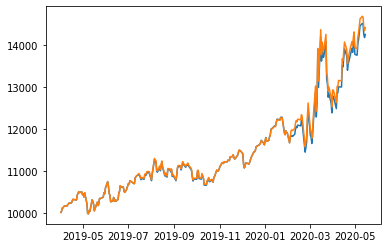

In [21]:
mult = bt.values.rename(columns={'Backtest':'Multiprocessing'})
no_mult = old_values.rename(columns={'Backtest':'No Multiprocessing'})
plt.plot(mult.index, mult, no_mult.index, no_mult)
plt.show()

In [22]:
mult.iloc[-1], no_mult.iloc[-1]

(Multiprocessing    14256.846894
 Name: 2020-05-15 00:00:00, dtype: float64,
 No Multiprocessing    14422.963859
 Name: 2020-05-15 00:00:00, dtype: float64)

### Multiprocessing Speedup
Use the cell below to evaluate how much multiprocessing speeds up things on your machine.

In [23]:
from time import time

In [24]:
bt = Backtester(
    10_000,
    prices,
    market_calendar='NYSE',
    start_date='1999-4-1',
    end_date=date.today()-relativedelta(weeks=1),
    strategy=my_strategy
)
# with multiprocessing
start = time()
bt.run()
end = time()
f'{(end-start):.2f} seconds'

'37.48 seconds'

In [ ]:
bt = Backtester(
    10_000,
    prices,
    market_calendar='NYSE',
    start_date='1999-4-1',
    end_date=date.today()-relativedelta(weeks=1),
    strategy=my_strategy
)
# without multiprocessing
start = time()
bt.run(0)
end = time()
f'{(end-start):.2f} seconds'

# Custom DailyPriceProvider
To use your own data points, you can implement your own ``DailyPriceProvider``.
The following will show a price provider that simply returns random numbers and seeds them with the symbol name, which could definitely come in handy to make backtests more exiting and even less predictable.

In [ ]:
from simple_back.price_providers import DailyPriceProvider
import numpy as np
import pandas as pd

In [ ]:
def str_to_int(s):
    int.from_bytes(s.encode(), 'little')

In [ ]:
class RandomPriceProvider(DailyPriceProvider):
    
    def __init__(self):
        self.symbols = {}
        self.drange = pd.date_range('2019-1-1','2020-1-1')
        super().__init__()
        
    def get_price(self, symbol, date=None, event=None):
        if symbol not in self.symbols:
            np.random.seed(str_to_int(symbol))
            self.symbols[symbol] = (np.random.rand(len(self.drange)*2)-.5).cumsum()
            self.symbols[symbol] = self.symbols[symbol]*100
            self.symbols[symbol] = self.symbols[symbol]+abs(self.symbols[symbol].min())
            self.symbols[symbol] = self.symbols[symbol]+np.random.randint(0,1_000)
        df = pd.DataFrame()
        df['date'] = self.drange
        df['open'] = self.symbols[symbol][::2]
        df['close'] = self.symbols[symbol][1::2]
        df.set_index('date')
        if date is not None:
            entry = df.loc[date]
        else:
            entry = df
        if event in ['open', 'close']:
            return df[event]
        if event is None:
            return entry
        raise Exception('event was neither "open" nor "close", but was still given')

In [ ]:
random_price = RandomPriceProvider()

In [ ]:
random_price['AAPL'].head()

In [ ]:
random_price['AAPL',:,'open'].plot()
plt.show()